[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)



# 多个模式（Multiple Schemas）

## 评审（Review）

We just covered state schema and reducers.

我们刚刚介绍了状态模式和 reducers。

Typically, all graph nodes communicate with a single schema. 

通常情况下，所有图节点都与单一模式进行通信。

Also, this single schema contains the graph's input and output keys / channels.

此外，该单一模式还包含图形的输入和输出键/通道。

## 目标（Goals）

But, there are cases where we may want a bit more control over this:

但是，有些情况下我们可能希望对此有更多的控制：

* Internal nodes may pass information that is *not required* in the graph's input / output.

*内部节点可能会传递在图的输入/输出中*不必要* 的信息。

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

* 我们可能还希望为图使用不同的输入/输出模式。例如，输出可能仅包含一个相关的输出键。

We'll discuss a few ways to customize graphs with multiple schemas.

我们将讨论几种使用多种模式定制图形的方法。



In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 私有状态（Private State）

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

首先，让我们讨论在节点之间传递 [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) 的情况。

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

这对于图形的中间计算逻辑中需要的任何内容都很有用，但与图形的整体输入或输出无关。

We'll define an `OverallState` and a `PrivateState`.

我们将定义一个 `OverallState` 和一个 `PrivateState`。

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

`node_2` 使用 `PrivateState` 作为输入，但输出写入到 `OverallState`。



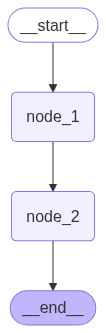

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`baz` 仅包含在 `PrivateState` 中。

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

`node_2` 使用 `PrivateState` 作为输入，但输出到 `OverallState`。

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

因此，我们可以看到 `baz` 被排除在图形输出之外，因为它不在 `OverallState` 中。



## 输入/输出模式（Input / Output Schema）

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

默认情况下，`StateGraph` 接受单一模式，并且所有节点都应与此模式进行通信。

However, it is also possible to [为图定义显式输入和输出模式](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

然而，也有可能 [为图定义显式输入和输出模式](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp)。

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

通常，这些情况下，我们定义一个“内部”模式，该模式包含 *所有* 与图形操作相关的键。

But, we use specific `input` and `output` schemas to constrain the input and output.

但是，我们使用特定的 `input` 和 `output` 模式来约束输入和输出。

First, let's just run the graph with a single schema.

首先，让我们使用单个 PROTECTED$1$ 模式运行图。



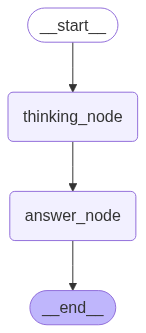

In [3]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke contains all keys in `OverallState`. 

请注意，invoke 的输出包含 `OverallState` 中的所有键。



In [5]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

现在，让我们在图形中使用特定的 `input` 和 `output` 模式。

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 

在这里，`input` / `output` 模式对图的输入和输出上允许的键进行 *过滤*。

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

此外，我们可以使用类型提示 `state: InputState` 来指定每个节点的输入模式。

This is important when the graph is using multiple schemas.

当图使用多个模式时，这一点很重要。

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 

我们在下面使用类型提示来，例如，显示 `answer_node` 的输出将被过滤为 `OutputState`。



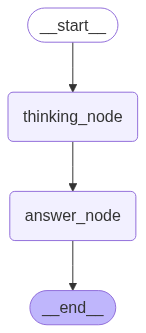

{'answer': 'bye Lance'}

In [4]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.

我们可以看到 `output` 模式将输出限制为仅包含 `answer` 键。

